In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy as sp
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import itertools
from colour import Color
from datetime import date
from scipy.stats import bootstrap
from statsmodels.stats.weightstats import ztest as ztest

In [2]:
today = date.today()
print("Today's date:", today)
date = str(today)
date

Today's date: 2023-08-31


'2023-08-31'

In [3]:
askmastersheet = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the selected file
data = pd.read_csv(askmastersheet, encoding='utf-8')
data 

,EXP_ID,CONDITION,TRACK_ID,TRACK_MEAN_SPEED (um/min),TRACK_MAX_SPEED (um/min),TRACK_DURATION (min),TRACK_DISPLACEMENT (um),TOTAL_DISTANCE_TRAVELED (um),CONFINEMENT_RATIO,INTERVAL (min)
0,20230803,Control,0,0.095340,0.272400,65.000007,0.681000,4.767003,0.142857,5
1,20230803,Control,1,0.190680,0.272400,25.000003,3.405002,4.767003,0.714286,5
2,20230803,Control,2,0.203652,0.799816,300.000034,3.668367,61.095628,0.060043,5
3,20230803,Control,3,0.145696,0.359580,300.000034,4.823901,43.708789,0.110365,5
4,20230803,Control,4,0.261398,0.738912,85.000010,2.749551,22.218820,0.123749,5
...,...,...,...,...,...,...,...,...,...,...
48190,20230817,Trichostatin 1uM,89,0.877320,1.428091,20.000000,1.231369,17.546406,0.070178,5
48191,20230817,Trichostatin 1uM,90,1.546515,3.733446,15.000000,14.888366,23.197726,0.641803,5
48192,20230817,Trichostatin 1uM,91,0.837844,0.844755,10.000000,6.454361,8.378436,0.770354,5
48193,20230817,Trichostatin 1uM,92,0.670108,0.670108,5.000000,3.350539,3.350539,1.000000,5


In [6]:
data['CONDITION'].unique()

array(['Control', 'DZA 100nM', 'Spastazoline 1uM', 'Taxol 100nM',
       'Trichostatin 100nM', 'DZA 1uM', 'Spastazoline 10uM', 'Taxol 1uM',
       'Trichostatin 1uM'], dtype=object)

In [9]:
rng = np.random.default_rng()

In [10]:
def bootstrap_ztest(data,parameter,statistic): #parameter e.g. 'TRACK_MEAN_SPEED (um/min)' #statistic e.g. np.mean
    
    data_ctl =  (data[(data['CONDITION']=='Control')][parameter],)
    res_ctl = bootstrap(data_ctl, statistic, confidence_level=0.9, n_resamples=1000,
                random_state=rng)
    df = pd.DataFrame(columns=[] , index=[])
    
    for condition in data['CONDITION'].unique():
        data_test = (data[(data['CONDITION']==condition)][parameter],)
        res_test = bootstrap(data_test, statistic, confidence_level=0.9, n_resamples=1000,
                random_state=rng)
        
        stat, pvalue = ztest(res_ctl.bootstrap_distribution, res_test.bootstrap_distribution, value=0)\
        
        star = 0
    
        if pvalue > 0.05:
            star = 0
        if pvalue <= 0.05:
            star = 1
        if pvalue <= 0.01:
            star = 2
        if pvalue <= 0.001:
            star = 3
        if pvalue <= 0.0001:
            star = 4
            
        d = {'Bootstrap': res_test.bootstrap_distribution}
        df0 = pd.DataFrame(data=d)
      
        df0['CONDITION'] = condition
        df0['Mean of Statistic'] = res_test.bootstrap_distribution.mean()
        #df0['Confidence Interval'] = res_test.confidence_interval
        df0['Z-test p-value'] = pvalue
        df0['Star'] = star
        
        df = pd.concat([df, df0], sort=False)
    
    return df

In [11]:
bootstrap_ztest(data,'TRACK_MEAN_SPEED (um/min)',np.mean)

,Bootstrap,CONDITION,Mean of Statistic,Z-test p-value,Star
0,0.579544,Control,0.578297,2.804096e-01,0
1,0.580636,Control,0.578297,2.804096e-01,0
2,0.571908,Control,0.578297,2.804096e-01,0
3,0.579236,Control,0.578297,2.804096e-01,0
4,0.586231,Control,0.578297,2.804096e-01,0
...,...,...,...,...,...
995,0.581153,Trichostatin 1uM,0.570726,5.008020e-96,4
996,0.585088,Trichostatin 1uM,0.570726,5.008020e-96,4
997,0.585900,Trichostatin 1uM,0.570726,5.008020e-96,4
998,0.560867,Trichostatin 1uM,0.570726,5.008020e-96,4


In [12]:
speeddf = bootstrap_ztest(data,'TRACK_MEAN_SPEED (um/min)',np.median)

In [15]:
data_ctl =  data[(data['CONDITION']=='Control')]
data_tx100 =  data[(data['CONDITION']=='Taxol 100nM')]
data_dza =  data[(data['CONDITION']=='DZA 1uM')]

(array([ 10.,   5.,  10.,  54.,  77.,  87., 120., 140., 138., 162., 163.,
        153., 162., 152., 135., 141., 129., 131., 114., 100., 105.,  91.,
         68.,  80.,  71.,  58.,  62.,  54.,  47.,  52.,  43.,  41.,  50.,
         27.,  28.,  28.,  24.,  18.,  23.,  24.,  17.,  14.,  10.,  10.,
         13.,  14.,   9.,   8.,  18.,   8.,   5.,   4.,   1.,   8.,   9.,
          5.,   9.,   3.,   3.,   3.,   4.,   4.,   6.,   3.,   5.,   7.,
          3.,   5.,   5.,   1.,   5.,   2.,   7.,   5.,   2.,   6.,   0.,
          2.,   2.,   3.,   2.,   1.,   2.,   0.,   1.,   2.,   5.,   3.,
          2.,   4.,   1.,   2.,   2.,   2.,   4.,   1.,   3.,   5.,   5.,
          6.]),
 array([0.        , 0.03978994, 0.07957988, 0.11936981, 0.15915975,
        0.19894969, 0.23873963, 0.27852956, 0.3183195 , 0.35810944,
        0.39789938, 0.43768932, 0.47747925, 0.51726919, 0.55705913,
        0.59684907, 0.636639  , 0.67642894, 0.71621888, 0.75600882,
        0.79579875, 0.83558869, 0.87537863, 0.

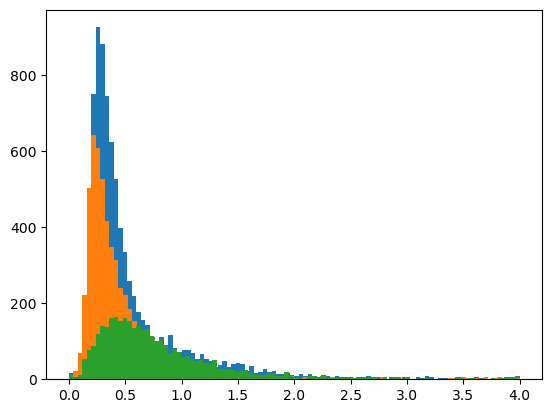

In [17]:
fig, ax = plt.subplots()
ax.hist(data_ctl['TRACK_MEAN_SPEED (um/min)'], bins=100)
ax.hist(data_tx100['TRACK_MEAN_SPEED (um/min)'], bins=100)
ax.hist(data_dza['TRACK_MEAN_SPEED (um/min)'], bins=100)

In [134]:
data_ctl_speed = (data_ctl['TRACK_MEAN_SPEED (um/min)'],)
res_ctl = bootstrap(data_ctl_speed, np.mean, confidence_level=0.9, n_resamples=100,
                random_state=rng)

In [135]:
data_spa_speed = (data_spa['TRACK_MEAN_SPEED (um/min)'],)
res_spa = bootstrap(data_spa_speed, np.mean, confidence_level=0.9, n_resamples=100,
                random_state=rng)

In [136]:
data_tx100_speed = (data_tx100['TRACK_MEAN_SPEED (um/min)'],)
res_tx100 = bootstrap(data_tx100_speed, np.mean, confidence_level=0.90, n_resamples=100,
                random_state=rng)

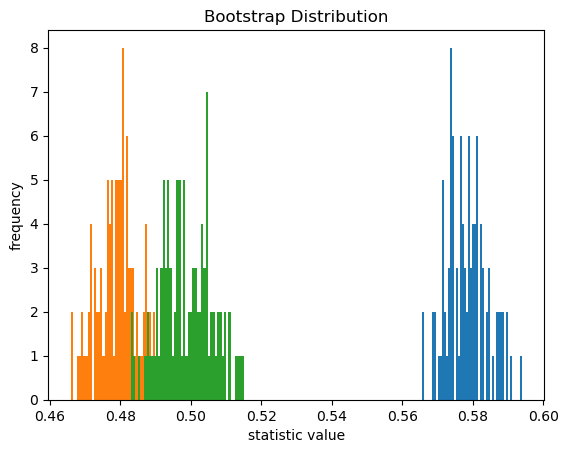

In [137]:
fig, ax = plt.subplots()
ax.hist(res_ctl.bootstrap_distribution, bins=50)
ax.hist(res_spa.bootstrap_distribution, bins=50)
ax.hist(res_tx100.bootstrap_distribution, bins=50)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [138]:
ztest(res_spa.bootstrap_distribution,res_tx100.bootstrap_distribution)

(-21.02207102137657, 4.1205625919537e-98)

(0.0, 1.0)

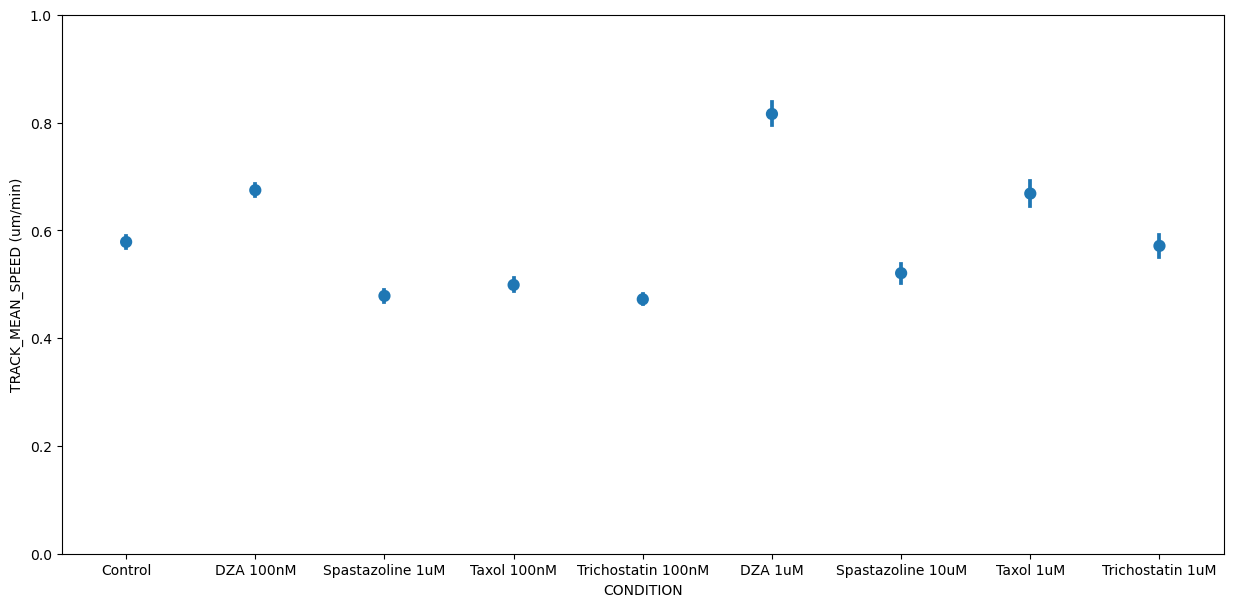

In [143]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.pointplot(data=data, x='CONDITION', y='TRACK_MEAN_SPEED (um/min)', errorbar = ('ci', 95), join = False,estimator='mean', n_boot=1000)
ax.set_ylim(0,1)